In [ ]:
import os
from tqdm.autonotebook import tqdm, trange
import time
from rich import print
import random
from pathlib import Path
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import cv2

from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Задаем параметры

In [13]:
DATA_DIR = '/home/user/Disk/CARS/CAR_DATA/img_with_masks_bbox' # Выберите свой путь
NUM_CLASSES = len([i for i in Path(os.path.join(DATA_DIR, "train")).glob("*")])
BATCH_SIZE = 24
WORKERS = 8
use_gpu = torch.cuda.is_available()

## Подготавливаем данные для обучения и задаем необходимые аугментации

In [136]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
}

In [137]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=WORKERS)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [138]:
print(dataset_sizes)

{'train': 3801, 'val': 1436, 'test': 604}

In [131]:
def visualize(path_to_data: DATA_DIR, folder="train", num_images=2):
    
    random.seed(11)
    
    path_to_images = [i for i in Path(os.path.join(path_to_data, folder)).rglob("*") if i.suffix.lower() in [".jpg", ".png", ".jpeg"]]
    #print(path_to_images)
    random_selection = random.choices(path_to_images, k=num_images)
    
    fig = plt.figure(figsize=(20,10))
    axes = fig.subplots(nrows=1, ncols=num_images)
    
    if num_images > 1:
        for i in range(num_images):
            image = cv2.imread(str(random_selection[i]))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i].imshow(image)
    else:
        image = cv2.imread(str(random_selection[-1]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes.imshow(image)
    plt.show()

**Исходные изображения**

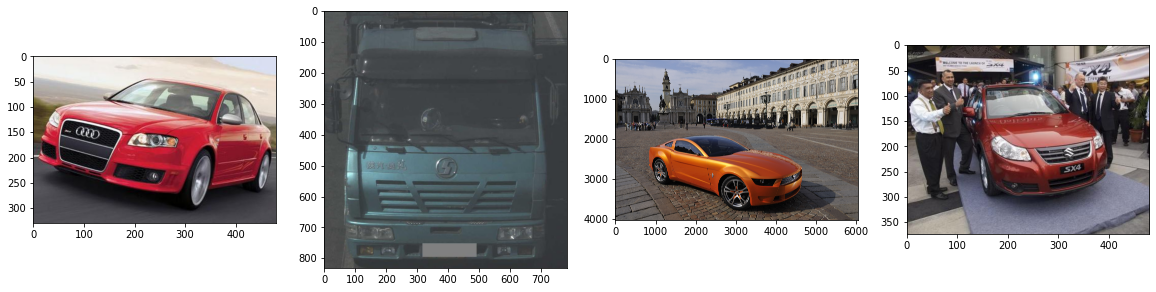

In [66]:
visualize(path_to_data="/home/user/Disk/CARS/CAR_DATA/data", num_images=4)

**Изображения, вырезанные по ограничивающей рамке (bbox)**

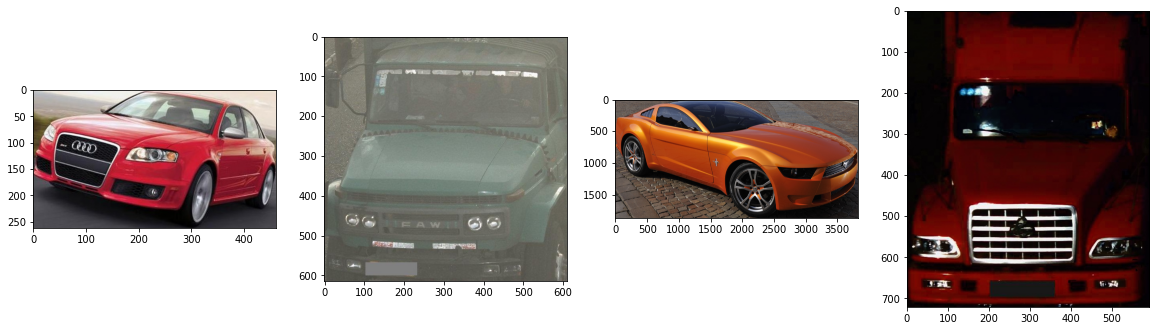

In [67]:
visualize(path_to_data="/home/user/Disk/CARS/CAR_DATA/bbox", num_images=4)

**Изображения, вырезанные по сегментированной маске**

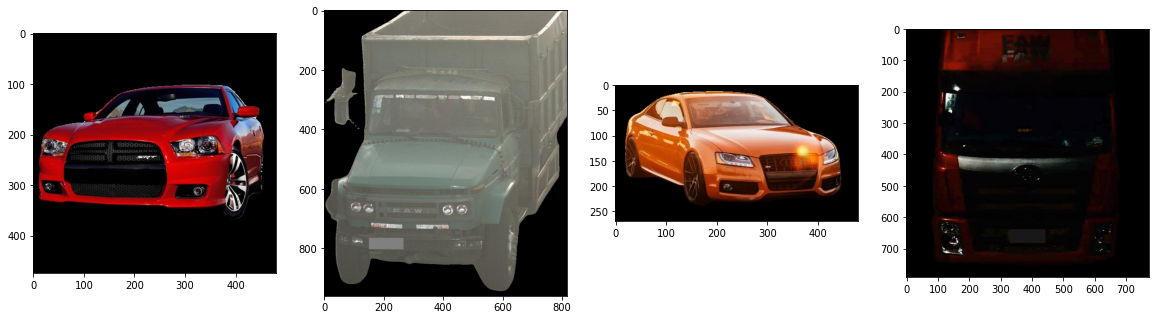

In [68]:
visualize(path_to_data="/home/user/Disk/CARS/CAR_DATA/img_with_masks", num_images=4)

**Изображения, вырезанные по сегментированной маске, затем обрезанные по ограничивающей рамке**

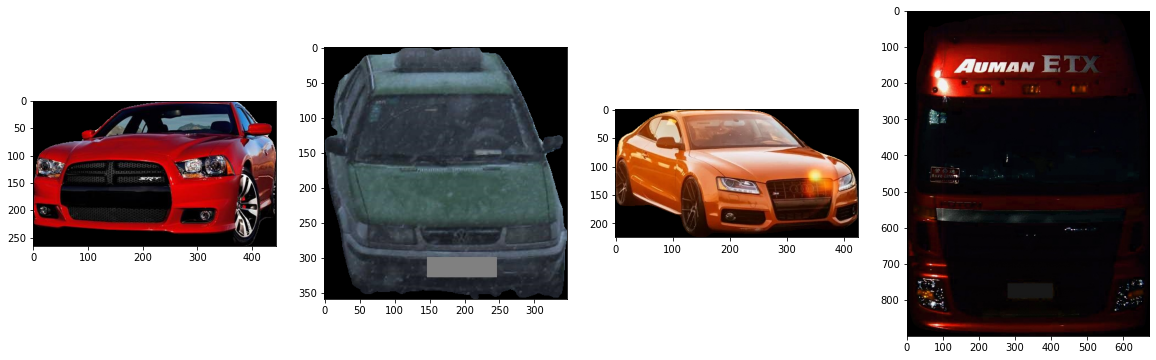

In [69]:
visualize(path_to_data="/home/user/Disk/CARS/CAR_DATA/img_with_masks_bbox", num_images=4)

## Фазы обучения и валидации модели

In [70]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], "val": []}
    accuracy = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждая эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses, accuracy

In [25]:
# def evaluate(model, dataloaders, dataset_sizes):
#     model.eval()
    
#     runninig_correct = 0
#     for data in tqdm(dataloaders['test'], total=len(dataloaders['test'])):
#         # получаем картинки и метки
#         inputs, labels = data
        
#         # переносим на gpu, если возможно
#         if use_gpu:
#             inputs = inputs.cuda()
#             labels = labels.cuda()
            
#         # forward pass
#         output = model(inputs)
#         _, predicted = torch.max(output, 1)
        
#         runninig_correct += int(torch.sum(predicted == labels))
    
#     return runninig_correct / dataset_sizes['test']

## Загрузка модели

In [72]:
model = models.alexnet(pretrained=True)

# model = timm.create_model("resnest101e", pretrained=True)

## Заменяем последний слой с 1000 классов (от ImageNet) на 11 классов 

In [73]:
num_features = model.classifier[-1].in_features

for param in model.parameters():
    param.requires_grad = True

model.classifier[-1] = nn.Linear(num_features, NUM_CLASSES)

# if use_gpu:
#     model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5)

In [74]:
model, losses, accuracy = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

train iter::   0%|          | 0/159 [00:00<?, ?it/s]

val iter::   0%|          | 0/60 [00:00<?, ?it/s]

Training complete in 6m 40s

Best val Acc: 0.990251

## Сохраняем модель и словарь со значениями функции потерь и точностью на трейне и валидации.

In [75]:
with open(f"/home/user/Disk/CARS/CAR_DATA/{Path(DATA_DIR).name}.json", "w") as f:
    dict_results = {"losses": losses,
                   "accuracy": accuracy}
    json.dump(dict_results, f)
    
torch.save(model, f"/home/user/Disk/CARS/CAR_DATA/{Path(DATA_DIR).name}.pth")

## Строим графики обучения

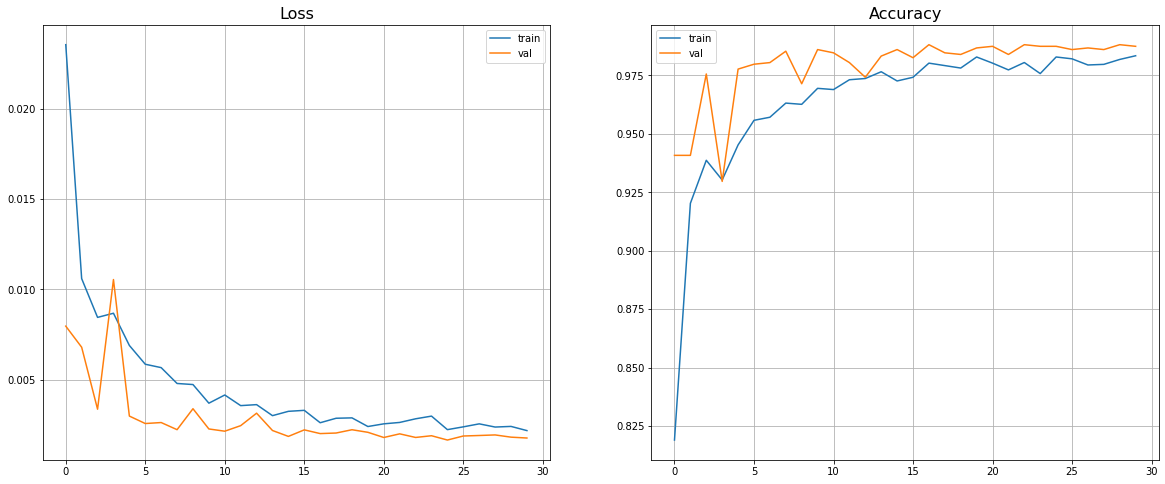

In [19]:
#sns.set(font_scale=1.4)
fig = plt.figure(figsize=(20,8))
axes = fig.subplots(nrows=1, ncols=2)

axes[0].plot(losses['train'], label="train")
axes[0].plot(losses['val'], label="val")

axes[1].plot(accuracy['train'], label="train")
axes[1].plot(accuracy['val'], label="val")

axes[0].set_title("Loss", fontsize=16)
axes[1].set_title("Accuracy", fontsize=16)

axes[0].legend()
axes[1].legend()
axes[0].grid()
axes[1].grid()
plt.show()

In [45]:
def conf_matrix(model, dataloaders, class_names):
    y_pred = []
    y_true = []

    for  i, data in enumerate(dataloaders['test']):
            inputs, labels = data
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else:
                inputs, labels = inputs, labels
            output = model(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) 

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) 
  
    #classes = class_names
    
    #print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)

    df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], index = [i for i in class_names],
                     columns = [i for i in class_names])
    plt.figure(figsize = (16,9))
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

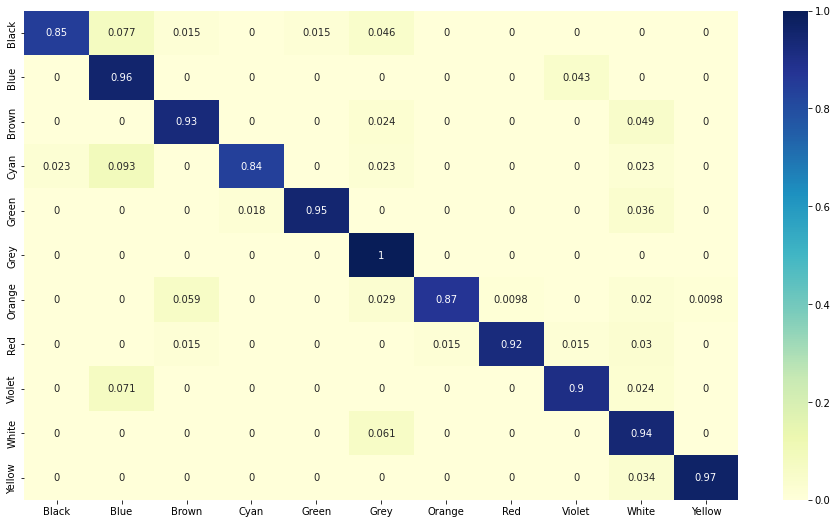

In [91]:
conf_matrix(model_masks_bbox, dataloaders, class_names)

## Сравнительный анализ результатов

In [36]:
with open(f"/home/user/Disk/CARS/CAR_DATA/data.json", "r") as f:
    data_json = json.load(f)
    
with open(f"/home/user/Disk/CARS/CAR_DATA/bbox.json", "r") as f:
    bbox_json = json.load(f)
    
with open(f"/home/user/Disk/CARS/CAR_DATA/img_with_masks.json", "r") as f:
    masks_json = json.load(f)
    
with open(f"/home/user/Disk/CARS/CAR_DATA/img_with_masks_bbox.json", "r") as f:
    masks_bbox_json = json.load(f)

In [37]:
def plot_comparison():
    
    dict_json_files = {"data": data_json, "bbox": bbox_json, "masks": masks_json, "masks_bbox": masks_bbox_json}
    
    fig = plt.figure(figsize=(20,8))
    axes = fig.subplots(nrows=1, ncols=2)

    for name, json_file in dict_json_files.items():

        losses = json_file["losses"]
        accuracy = json_file["accuracy"]

        #axes[0].plot(losses['train'], label="train")
        axes[0].plot(losses['val'], label=name)

        #axes[1].plot(accuracy['train'], label="train")
        axes[1].plot(accuracy['val'], label=name)

        axes[0].set_title("Loss", fontsize=16)
        axes[1].set_title("Accuracy", fontsize=16)

        axes[0].legend()
        axes[1].legend()
    axes[0].grid()
    axes[1].grid()
    plt.show()

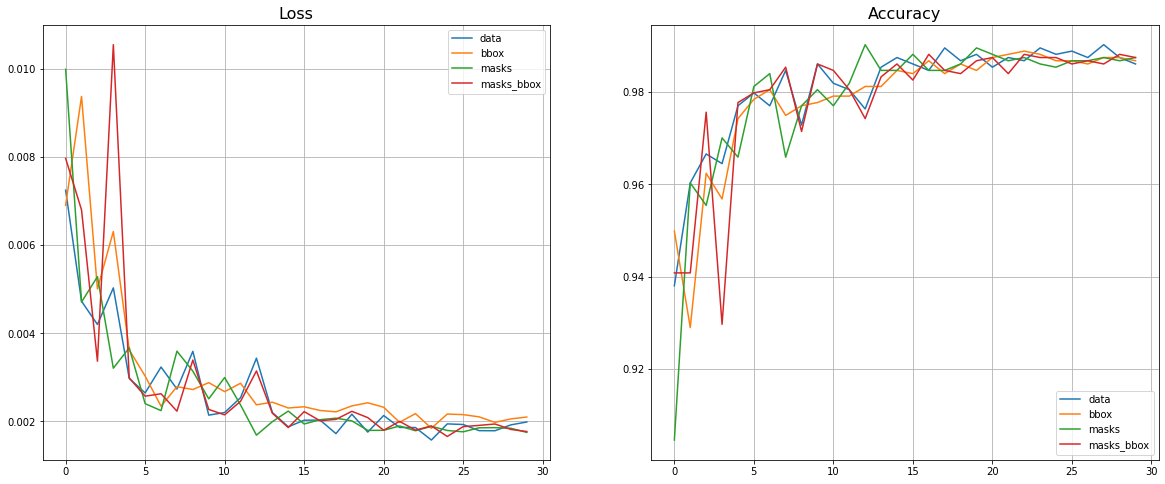

In [38]:
plot_comparison()

In [52]:
def evaluate(model, dataloaders, dataset_sizes):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['test']: #total=len(dataloaders['test'])):
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forward pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
    
    return runninig_correct / dataset_sizes['test']

In [53]:
def inference(DATA_DIR: Path):
    
    data_transforms = {
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(244),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]),
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                              data_transforms[x])
                      for x in ['test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=WORKERS)
                   for x in ['test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
    class_names = image_datasets['test'].classes
    
    model = torch.load(f"/home/user/Disk/CARS/CAR_DATA/{DATA_DIR.name}.pth")
    
    print(f"Name model: {DATA_DIR.name}, Accuracy: {evaluate(model, dataloaders, dataset_sizes):.4f} \n")
    
    conf_matrix(model, dataloaders, class_names)
    
    return model

In [54]:
dirs = ["/home/user/Disk/CARS/CAR_DATA/data", "/home/user/Disk/CARS/CAR_DATA/bbox",
       "/home/user/Disk/CARS/CAR_DATA/img_with_masks", "/home/user/Disk/CARS/CAR_DATA/img_with_masks_bbox"]

for _dir in dirs:
    inference(DATA_DIR=Path(_dir))

Name model: data, Accuracy: 0.9520

precision    recall  f1-score   support

       Black       0.97      0.95      0.96        65
        Blue       0.83      0.98      0.90        46
       Brown       0.87      0.95      0.91        41
        Cyan       1.00      0.87      0.93        15
       Green       1.00      1.00      1.00        56
        Grey       0.90      0.96      0.93        47
      Orange       1.00      0.93      0.96       102
         Red       0.97      0.95      0.96        66
      Violet       0.93      0.88      0.90        42
       White       0.98      0.95      0.97        66
      Yellow       0.98      0.98      0.98        58

    accuracy                           0.95       604
   macro avg       0.95      0.95      0.95       604
weighted avg       0.96      0.95      0.95       604

Name model: bbox, Accuracy: 0.9570

precision    recall  f1-score   support

       Black       0.98      0.95      0.97        65
        Blue       0.83      0.98      0.90        46
       Brown       0.91      0.95      0.93        41
        Cyan       0.87      0.87      0.87        15
       Green       0.98      0.95      0.96        56
        Grey       0.94      1.00      0.97        47
      Orange       1.00      0.96      0.98       102
         Red       0.96      0.98      0.97        66
      Violet       0.97      0.88      0.93        42
       White       0.98      0.95      0.97        66
      Yellow       0.98      0.97      0.97        58

    accuracy                           0.96       604
   macro avg       0.95      0.95      0.95       604
weighted avg       0.96      0.96      0.96       604

Name model: img_with_masks, Accuracy: 0.9669

precision    recall  f1-score   support

       Black       1.00      0.97      0.98        65
        Blue       0.87      1.00      0.93        46
       Brown       0.93      0.90      0.91        41
        Cyan       1.00      0.93      0.97        15
       Green       1.00      1.00      1.00        56
        Grey       0.92      1.00      0.96        47
      Orange       0.98      0.96      0.97       102
         Red       0.98      0.97      0.98        66
      Violet       0.97      0.88      0.93        42
       White       0.98      0.98      0.98        66
      Yellow       0.98      0.98      0.98        58

    accuracy                           0.97       604
   macro avg       0.97      0.96      0.96       604
weighted avg       0.97      0.97      0.97       604

Name model: img_with_masks_bbox, Accuracy: 0.9586

precision    recall  f1-score   support

       Black       1.00      0.98      0.99        65
        Blue       0.87      0.98      0.92        46
       Brown       0.88      0.93      0.90        41
        Cyan       0.87      0.87      0.87        15
       Green       1.00      0.96      0.98        56
        Grey       0.92      1.00      0.96        47
      Orange       0.98      0.94      0.96       102
         Red       0.96      0.98      0.97        66
      Violet       0.97      0.88      0.93        42
       White       0.98      0.95      0.97        66
      Yellow       1.00      0.98      0.99        58

    accuracy                           0.96       604
   macro avg       0.95      0.95      0.95       604
weighted avg       0.96      0.96      0.96       604